# Error Mitigation using Pauli Propagation

Since hardware-related errors on quantum computers cannot be fully error-corrected yet, many classical techniques have been developed to account for these errors.
This is known as **Quantum Error Mitigation**, a classical post-processing step for calculations on NISQ quantum computers.

Currently, error mitigation is a crucial step to make data from a quantum computer usable. From another view point, error mitigation can also benefit purely classical simulations by pushing the boundaries of executable computations within the PP framework. This idea will become clearer throughout the notebook.

For the correction of expectation values of observables, the leading error mitigation techniques are zero-noise extrapolation (ZNE) and probabilistic error cancellation (PEC). To get an overview of common methods, the [mitiq documentation](https://mitiq.readthedocs.io/en/stable/guide/guide.html) is very useful, especially the "What is the theory behind ...?" subheaders. 

However, these techniques come with a cost: they imply an overhead in terms of quantum resources. In the case of the IBM utility experiment, ZNE required running over half a million quantum circuits! In this notebook, we achieve similar levels of error mitigation using Pauli Propagation (PP). It requires no overhead in quantum resources and it can (in certain cases) be run in only a few minutes of computation on a laptop (though, it could take much longer depending on the truncation coefficients chosen). This notebook should run in roughly 5 minutes, as long as you do not change the currently set truncation coefficients ; ).

Here is an overview of what we will cover in this notebook:

- We will start with the most intuitive and widely used error mitigation method, Zero Noise Extrapolation (ZNE).

- Then we will focus on an error mitigation technique called Clifford Data Regression (CDR) [[Czarnik et al., Quantum 2021](https://quantum-journal.org/papers/q-2021-11-26-592/)], and an extension to this method, Clifford Perturbation Approximation (CPA) [[Begusic et al., J. Chem. Phys. 2025](https://pubs.aip.org/aip/jcp/article-abstract/162/15/154110/3344130/Simulating-quantum-circuit-expectation-values-by?redirectedFrom=fulltext)].

- Next, we can combine these two approaches to create a generalised error mitigation scheme. This technique is called variable noise CDR (CDR + ZNE = vnCDR) [[Lowe et al., Phys. Rev. Res. 2021](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.033098)]. We are in fact combining CPA and ZNE to Clifford Perturbation Data Regression - ZNE (CPDR - ZNE), but the main principle stays the same [[Zhang et al., arXiv 2024](http://arxiv.org/abs/2412.09518)]. 

- Finally, we apply these methods on IBM's utility experiment [[Kim et al., Nature 2023](https://www.nature.com/articles/s41586-023-06096-3)].

DISCLAIMERS:

We know the notebook is quite long. All error mitigation methods are independent of each other, so you could for example only look at ZNE and the final overview plot of the utility experiment.

If you plan to perform error mitigation using PP and use some of our code, we advise you to have a look at our 'advanced' notebook as well. There, we present additional methods we have developed and use a code base instead of this self-contained approach (https://github.com/JuliaGerecke/PP-EM).

In [1]:
# necessary imports
using PauliPropagation
using Plots
using DataFrames
using Logging
using Distributions
using LaTeXStrings
using MLJLinearModels
using MLJBase
using LsqFit

# Target circuit

The system we are interested in simulating is the transverse-field Ising model (TFIM) on a heavy-hex lattice, where the Hamiltonian is
$$
 H = -J\sum_{<i,j>}Z_iZ_j+h\sum_i X_i .
 $$
The first-order Trotterization of the time-dependent Schrödinger equation is
$$
\begin{aligned}
 |\psi(T)\rangle &= \prod_{k=1}^N e^{-i\frac{T}{N}H} |\psi(0)\rangle \\
    &\approx \prod_{k=1}^N \left(\prod_{<i,j>} e^{i \frac{JT}{N}Z_i Z_j } \prod_i e^{-i \frac{hT}{N}X_i} \right) |\psi(0)\rangle \\
    &= \prod_{k=1}^N \left[ \prod_{<i,j>} R_{Z_i Z_j} \left(\theta_J\right) \prod_i R_{X_i}\left(\theta_h\right) \right] |\psi(0)\rangle
\end{aligned}
$$

where $T$ is the final time, $N$ is the number of time steps, $\displaystyle\theta_J= -\frac{2TJ}{N}$ and $\displaystyle\theta_h = \frac{2Th}{N}$.

We start by defining our target circuit within PP and visualizing the time evolution we want to correct. This is done for visualization purposes only in this notebook. Here, we use moderate truncations, with `min_abs_coeff=1e-6` and `max_weight=15`. The simulations can be done exactly only for small and shallow circuits if we do not use any truncations. By default, PP truncates below `min_abs_coeff=1e-10` if we don't set a truncation order.  Recall that in practice, the 'ground truth' comparison may well not be available for interesting problem sizes.

In [2]:
## CIRCUIT PARAMETERS
## number of qubits
nq = 31 

## number of steps (layers)
steps = 20 

## time step
dt = 0.05

## final time
T = steps*dt

## physical parameters of the model
J =  2.0 # J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0  # in ordered phase: abs(h) < abs(J)

## truncations coefficients
min_abs_coeff=1e-6
max_weight=15

## TOPOLOGY
## 3 loops of heavy hex: works only with 31 qubits
topology = [(1, 2), (1, 15), (2, 3), (3, 4), (4, 5), (5, 6), (5, 16), (6, 7), (7, 8), (8, 9), (9, 10), (9, 17),
           (10, 11), (11, 12), (12, 13), (13, 14), (13, 18), (15, 19), (16, 23), (17, 27), (18, 31), (19, 20),
           (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28),
            (28, 29), (29, 30), (30, 31)];

#topology=bricklayertopology(nq)  

## OBSERVABLE
## ⟨ZZ⟩
observable = PauliSum(nq);    
for i in 1:length(topology)
    q1 = topology[i][1]
    q2 = topology[i][2]
    add!(observable, [:Z, :Z], [q1, q2]);
end
observable = observable/length(topology);

## magnetization ⟨Z⟩
# observable = PauliSum(nq)
# for i in 1:nq
#     add!(observable,:Z, i)
# end
# observable = observable/nq;

## <Z_15>
# observable = PauliSum(nq)
# add!(observable, :Z, 15);

PauliSum(nqubits: 31, 33 Pauli terms:
 0.030303 * IIIIIIIIIIIIIIIIIIII...
 0.030303 * IZZIIIIIIIIIIIIIIIII...
 0.030303 * IIIIIIIIIIIIIIIIIIII...
 0.030303 * IIIIIIIIZZIIIIIIIIII...
 0.030303 * IIIIIIIIIIIIIIIIIIII...
 0.030303 * IIIIIIIIIIIIZZIIIIII...
 0.030303 * IIIIIIIIIIIIIIIIIIII...
 0.030303 * IIIIIIIIIIIZZIIIIIII...
 0.030303 * IIIIZZIIIIIIIIIIIIII...
 0.030303 * IIIIIZZIIIIIIIIIIIII...
 0.030303 * IIIIIIIZZIIIIIIIIIII...
 0.030303 * IIIIIIIIZIIIIIIIZIII...
 0.030303 * IIIIIIIIIIIIIIZIIIZI...
 0.030303 * IIIIIIIIIIIIIIIIIZII...
 0.030303 * IIIIIIIIIIIIIIIZIIII...
 0.030303 * IIIIIIIIIIIIIIIIIIII...
 0.030303 * IIIIIIIIIIIIIIIIIIII...
 0.030303 * IIIIIIIIIZZIIIIIIIII...
 0.030303 * IIIIIIIIIIIIIIIIIIIZ...
 0.030303 * IIIIIIIIIIIIIIIIIIII...
  ⋮)

If we choose the $\langle ZZ \rangle $ observable, the PauliSum has as many terms as edges in the graph of the topology. In this case, for 31 qubits (nodes) in the heavy-hex topology, there are 33 terms connecting the nodes (edges). To save memory, we could also propagate each Pauli string of the observable individually. While this slows down the computation, it reduces the peak memory usage.

We will create a circuit made out of parameterized gates. To perform the simulation, we need to provide the parameters of the gates to the `propagate` function. In the present case, our parameterized gates are Pauli rotations and the parameters are the angles $\theta_h$ and $\theta_J$. We define the function `define_thetas` that will set up our vector of angles.

In [3]:
function define_thetas(circuit::Vector{Gate}, dt::Float64, J::Float64=2.0, h::Float64=1.0)
    # get indices indicating which angle corresponds to which gate 
    rzz_indices = getparameterindices(circuit, PauliRotation, [:Z, :Z])
    rx_indices = getparameterindices(circuit, PauliRotation, [:X])
    
    nparams = countparameters(circuit)
    thetas = zeros(nparams)
    
    # following eq. (3)
    thetas[rzz_indices] .= - J * dt * 2
    thetas[rx_indices] .= h * dt * 2

    return thetas
end;

Let's compute the approximate noiseless expectation and noisy expecation value for our circuit. For both, we need one `layer` of the circuit, which we can then propagate for the number of `steps` of duration `dt` each.

In [4]:
# define 1 layer of the trotterized TFIM circuit
layer = tfitrottercircuit(nq, 1, topology=topology)
thetas = define_thetas(layer, dt, J, h);

For the noisy circuits, we'll define a function `applynoiselayer`, which adds depolarizing and dephasing noise in the **Pauli Transfer Matrix (PTM)** formalism.

In [5]:
function applynoiselayer(psum::PauliSum;depol_strength=0.02, dephase_strength=0.02, noise_level=1.0)
    for (pstr, coeff) in psum
        set!(psum, pstr, 
            coeff*(1-noise_level*depol_strength)^countweight(pstr)*(1-noise_level*dephase_strength)^countxy(pstr))
    end 
end

applynoiselayer (generic function with 1 method)

In Pauli Propagation, there is also a higher level noise implementation, which looks for example like this: `depol_noise_layer = [DepolarizingNoise(qind, depol_strength) for qind in 1:nq];`. This gives the same results as our code, but requires to loop over the number of qubits for both noise kinds, so we instead opt for the `applynoiselayer` implementation above, equivalent to the one in Pauli Propagation under the hood.

Note that the `depol_strength` (and `dephase_strength`) arguments in the `applynoiselayer` function are not simply the single gate error probabilites as one might assume, rather they are related to those via a multiplicative factor which depends on the noise kind. You can safely skip this section for now, but it will be useful if you are trying to implement a circuit with certain gate error probabilities.

<details>
<summary> Explanation of the noise layer implementation in PTM formalism </summary>

The PP algorithm works in the Heisenberg picture. This can be conveniently implemented using the PTM formalism. A PTM represents a quantum channel $\mathcal{E}$ as a linear map on the vector space spanned by Pauli operators.

Let $\{P_i\}$ be the normalized Pauli basis (e.g., $I, X, Y, Z $ for one qubit). The action of $\mathcal{E}$ on this basis is

$$
\mathcal{E}(P_j) = \sum_i R_{ij} P_i,
$$

where $R$ is the PTM and its elements are given by

$$
R_{ij} = \frac{1}{2^n} \operatorname{Tr}\left[P_i \, \mathcal{E}(P_j)\right].
$$

Let's apply this to our noise model:

The depolarizing channel with probability $q$ in the Schrödinger picture is

$$
\mathcal{E}(\rho) = (1 - q)\rho + \frac{q}{3}(X\rho X + Y\rho Y + Z\rho Z).
$$

We can then compute the Pauli Transfer Matrix (PTM) to be

$$
R_{\text{dep}} =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 - \tfrac{4p}{3} & 0 & 0 \\
0 & 0 & 1 - \tfrac{4p}{3} & 0 \\
0 & 0 & 0 & 1 - \tfrac{4p}{3}
\end{bmatrix}.
$$
(You can check this by calculating for example $\mathcal{E}(X)$ by hand.)

The dephasing channel with probability $q$ is

$$
\mathcal{E}(\rho) = (1 - p)\rho + p Z\rho Z.
$$

We find its PTM to be

$$
R_{\text{deph}} =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 - 2p & 0 & 0 \\
0 & 0 & 1 - 2p & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}.
$$

In our noise model, we assume the noise to act **independently on each qubit**. If a single-qubit Pauli operator $P$ is transformed under noise as:

$$
P \to \lambda P,
$$

then for a multi-qubit Pauli string $ P^{\otimes n} = P_1 \otimes P_2 \otimes \dots \otimes P_n $, the full transformation is

$$
P_1 \otimes P_2 \otimes \dots \otimes P_n \to \lambda_1 P_1 \otimes \lambda_2 P_2 \otimes \dots \otimes \lambda_n P_n = \left( \prod_i \lambda_i \right)(P_1 \otimes \dots \otimes P_n).
$$

If the shrinkage factor per qubit is $\lambda$, and $k$ qubits are affected, then the total multiplicative factor is $\lambda^k$.

Let's look at the formula for the depolarizing noise:

The shrinkage factor is `(1-noise_level*\frac{4}{3}*q)`. Only the non-identity Paulis are affected (check the PTM!), of which there are `countweight(pstr)`.  We now see that `depol_noise = \frac{4}{3}*q` to get the formula as in the `applynoiselayer` function.  

The same is done for the dephasing noise, but now, the $k$ qubits affected are found by `countxy(pstr)` as you can see from the PTM. The shrinkage factor $\lambda$ is `(1-noise_level*2*q)`, so `dephase_noise = 2*q`.

Even though we are in the PTM formalism, the PP algorithm does not use matrix-multiplication in its implementation under the hood as it would become computationally unfeasible very quickly! Since explaining this brings us too far down the rabbit hole, check out the Pauli Propagation paper if you are interested [[Rudolph et al., arXiv 2025](https://arxiv.org/abs/2505.21606)].

</details>


For later convenience, it is best to define a `trotter_time_evolution` function, which we can use for all our error mitigation methods. We give it a few extra arguments not used yet that will be useful later.

In [6]:
function trotter_time_evolution(
    steps::Int, layer::Vector{Gate}, observable::PauliSum, thetas::Vector{Float64};
    noise=false, min_abs_coeff=1e-10, max_weight=Inf,
    depol_strength=0.02, dephase_strength=0.02, noise_level=1.0,
    output_psum=false
)
    obs = deepcopy(observable)
    expvals = [overlapwithzero(obs)]
    psum = obs  # initialize to have it in scope

    for _ in 1:steps
        psum = propagate!(layer, obs, thetas; min_abs_coeff, max_weight)
        
        if noise
            applynoiselayer(psum; depol_strength, dephase_strength, noise_level)
        end

        push!(expvals, overlapwithzero(psum))
    end

    return output_psum ? (expvals, psum) : expvals
end

trotter_time_evolution (generic function with 1 method)

We can now compute the noiseless time evolution of our circuit, by using the keyword argument `noise = false` (default setting).

In [7]:
 elapsed_noiseless = @elapsed exact_expval_target, psum_target = trotter_time_evolution(
  steps, layer, observable, thetas;
  noise=false,
  min_abs_coeff, max_weight, output_psum=true);

Now, we compute the corresponding noisy evolution. We add depolarizing and dephasing noise after each layer.
The strength was tuned manually to roughly approximate the noise level of experimental data from IBM utility experiment, to make sure we are correcting realistic noise.
This data would normally be real hardware data, but for small systems, we can simulate the noisy data.

In [8]:
depol_strength = 4/3*0.018 # 0.018 is error probability of depolarizing channel
dephase_strength = 2*0.012; # 0.012 is error probability of dephasing channel

In [9]:
 noisy_expval_target = trotter_time_evolution(
  steps, layer, observable, thetas;
  noise=true,
  min_abs_coeff, max_weight,
  depol_strength, dephase_strength);

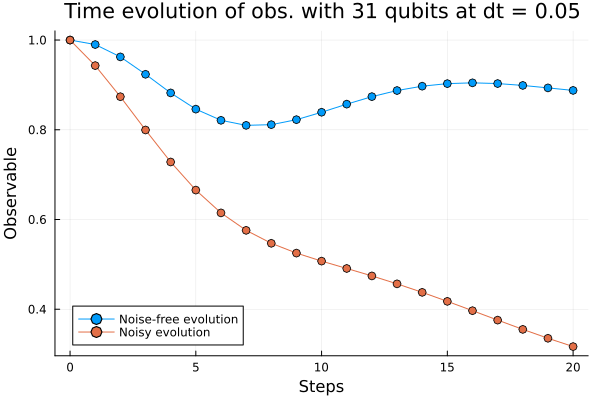

In [10]:
plot(0:steps, exact_expval_target, xlabel="Steps", label="Noise-free evolution", marker=:o)
plot!(0:steps, noisy_expval_target, label="Noisy evolution", marker=:o)

plot!(ylabel="Observable", title ="Time evolution of obs. with $(nq) qubits at dt = $(round((T/steps), digits = 2))")


As we can see from the plot above, the noise affects the expectation value. Instead of following the exact evolution in blue, the noise model causes the expectation value to evolve according to the orange line.

How can we recover the exact expectation value, given only the noisy data? 

# ZNE
The most intuitive error mitigation strategy is zero-noise extrapolation, where noise in a quantum circuit is artificially scaled to a set of noise levels, and then extrapolated to the zero-noise limit.

On a quantum computer, this can be done by inserting identity gates (mapping a gate $G$ to $\mathbb{I} G$) or with unitary folding (mapping a gate $G$ to $GG^\dagger G$). Instead of using a quantum computer for noisy data, we simulate the noisy circuits within Pauli Propagation by building a generic noise model. Here, we can directly set the noise levels to the desired values.
 
Performing ZNE using PP offers two main advantages:
- You don't need to adjust or add noise on your quantum hardware, thus avoiding potentially cumbersome circuit modifications.
- Noisy simulations are actually easier than the noiseless ones with PP: depolarizing noise shrinks the accessible Bloch sphere, thus reducing the coefficient of terms different from the maximally mixed state. If the coefficients are small enough (which occurs at high enough noise levels), they can be truncated.

From a perspective of purely classical simulations, using ZNE means we can calculate expectation values for systems that are no longer simulatable without noise. Pauli Propagation is often memory-limited, so there will be a range of systems where the noiseless computations are not executable, but ZNE will still work with a sufficiently high base noise level on the circuit. Note that increasing the base noise level will deteriorate the extrapolation, so this approach also has its limitations. To showcase this idea, we will keep track of the number of Pauli strings and the execution time at each noise level.

First, we calculate the noisy expectation values for a set of `noise_levels`.

In [11]:
noise_levels = [1.0,1.3,1.5,1.8,2.0,2.2]
num_pauli_terms = Int[]
execution_times = Float64[]

# performing the trotter time evolution for each noise level
noisy_expval_target_levels = Array{Float64,2}(undef, length(noise_levels), steps+1)
for (idx, level) in enumerate(noise_levels)
    elapsed = @elapsed expval_target, psum = trotter_time_evolution(
        steps, layer, observable, thetas;
        noise=true, noise_level=level,
        min_abs_coeff, max_weight,
        depol_strength, dephase_strength, output_psum=true)
    noisy_expval_target_levels[idx, :] .= expval_target
    push!(execution_times, elapsed)
    push!(num_pauli_terms, length(psum.terms))
end

In [12]:
println("Number of terms in the noiseless propagated observable: $(length(psum_target.terms)), execution time: $(round(elapsed_noiseless,digits = 2)) seconds.")
println("Noise levels: $noise_levels")
println("Respective number of terms in propagated observable: $num_pauli_terms")
println("Execution times for each noise level in seconds: $execution_times")


Number of terms in the noiseless propagated observable: 434456, execution time: 4.34 seconds.
Noise levels: [1.0, 1.3, 1.5, 1.8, 2.0, 2.2]
Respective number of terms in propagated observable: [23018, 10848, 6810, 3661, 2574, 1810]
Execution times for each noise level in seconds: [0.460966997, 0.285691898, 0.223115599, 0.1499437, 0.131170499, 0.106674699]


This shows us that indeed, the Pauli noise "helps" us by making the simulations easier. We can also see this directly from the `applynoiselayer` function. For depolarizing noise, we exponentiate a number smaller than 1 by the number of non identities, so the coefficients of each Pauli string are reduced with each application of noise. Combined with the `min_abs_coeff` truncation, we drop a large portion of the terms in the Pauli sum.

 Now that we have our noisy evolutions, let's mitigate the errors of our base line noisy simulation.
We have the freedom to choose an ansatz which best matches our noise model. For that, we plot only the last step of the time evolution in semi-log scale.

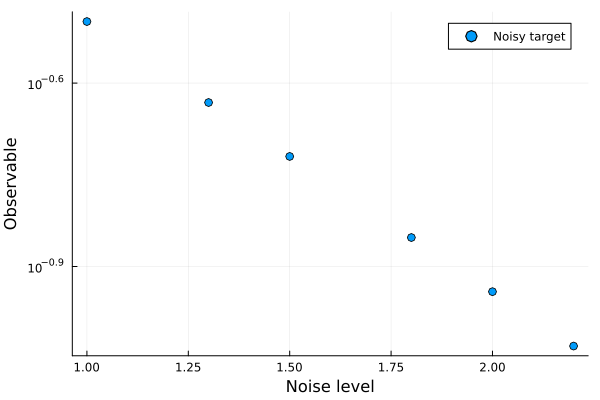

In [13]:
noisy_exp_last = noisy_expval_target_levels[:,end];
scatter(noise_levels, noisy_exp_last,
     xlabel="Noise level",
     ylabel="Observable",
     label="Noisy target",
     marker=:o,
     legend=:topright, yaxis=:log)

We see that an exponential fit is a good choice (the points are nearly on a line on a logarithmic scale), so we can define an ansatz, `exp_model`, to describe the dependence between the noise level and the expectation value.

In [14]:
# exponential model
exp_model(x, p) = p[1] .+ p[2] .* exp.(-p[3] .* x);

We can fit functions in `Julia` using the `curve_fit` function from the package `LsqFit`. We need to set initial parameters so the underlying algorithm can optimize them. We then evaluate the corrected value at zero noise.

In [15]:
# initial guess of the coefficient
p0 = [noisy_exp_last[end], noisy_exp_last[1] - noisy_exp_last[end], 1.0]

fit_ = curve_fit(exp_model, noise_levels, noisy_exp_last, p0)

# extrapolate to 0-noise using the fitted model
corrected_ZNE_last = exp_model(0.0, fit_.param)

0.8728654919709822

We can compare this to the absolute error before correction.

In [16]:
# absolute errors before and after correction 
abs_error_before_ZNE_last = abs(exact_expval_target[end] - noisy_exp_last[1]) 
abs_error_after_ZNE_last = abs(exact_expval_target[end] - corrected_ZNE_last) 

println("Noisy value: ", round(noisy_exp_last[1], digits = 2))
println("Corrected value: ", round(corrected_ZNE_last, digits = 2))
println("Absolute error before correction: ", round(abs_error_before_ZNE_last, digits = 2))
println("Absolute error after correction: ",round(abs_error_after_ZNE_last, digits = 5))

Noisy value: 0.32
Corrected value: 0.87
Absolute error before correction: 0.57
Absolute error after correction: 0.01491


Let's encapsulate this fitting procedure for a single time step in a function to simplify the next steps.

In [17]:
function zne(noisy_exp::Vector{Float64}, noise_levels::Vector{Float64}; exact_exp::Union{Nothing, Float64}=nothing)
    model(x, p) = p[1] .+ p[2] .* exp.(-p[3] .* x)
    p0 = [noisy_exp[end], noisy_exp[1] - noisy_exp[end], 1.0]
    fit_ = curve_fit(model, noise_levels, noisy_exp, p0)
    corrected = model(0.0, fit_.param)

    if exact_exp === nothing
        return corrected, nothing, nothing
    end

    abs_error_after = abs(exact_exp - corrected)
    abs_error_before = abs(exact_exp - noisy_exp[1])
    return corrected, abs_error_after, abs_error_before
end;


## example of a function call to compute the corrected value at the last time step:
# corr_ZNE_last,
# abs_error_after_ZNE_last,
# abs_error_before_ZNE_last = zne(noisy_exp_last, noise_levels, exact_expval_target[end])

zne (generic function with 1 method)

Now, we perform ZNE for each time step and visualize how good the correction over time is.

In [18]:
corrected_ZNE = Array{Float64, 1}(undef, steps+1)
abs_error_after_ZNE = Array{Float64, 1}(undef, steps+1)
abs_error_before_ZNE = Array{Float64, 1}(undef, steps+1)
for i in 1:steps+1
    corrected_ZNE[i],
    abs_error_after_ZNE[i],
    abs_error_before_ZNE[i] = zne(noisy_expval_target_levels[:,i], noise_levels; exact_exp = exact_expval_target[i])
end

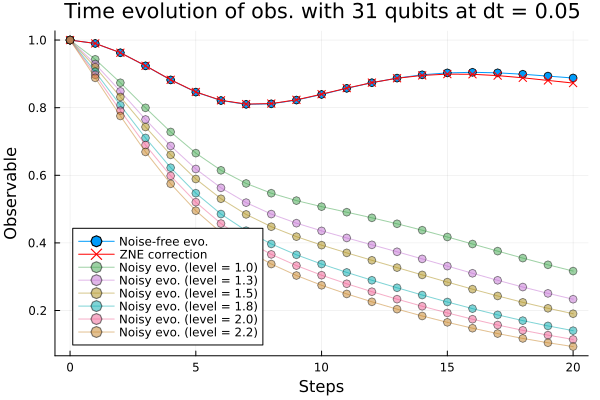

In [19]:
plot(0:steps, exact_expval_target, xlabel="Steps", label="Noise-free evo.", marker=:o, legend=:bottomleft)
plot!(0:steps, corrected_ZNE, label="ZNE correction", marker=:x, color ="red")

for i in 1:length(noise_levels)
    plot!(0:steps, noisy_expval_target_levels[i,:], label="Noisy evo. (level = $(noise_levels[i]))", marker=:o, alpha = 0.5)
end
plot!(ylabel="Observable", title ="Time evolution of obs. with $(nq) qubits at dt = $(round((T/steps), digits = 2))")

ZNE works well for this noise model. However, one must ensure that the noise is not too dominant. If so, the system thermalizes and the noisy values all converge to the same value regardless of the noise strength. In this case, one cannot extrapolate anymore. 

# Clifford Data Regression (CDR) 
Instead of using variable-noise data (ZNE), the CDR approach performs error mitigation using variable near-Clifford circuit data. According to the Gottesman-Knill theorem, fully Clifford circuits can be simulated efficiently classically. Since only using Clifford circuits as a training set does not provide sufficient expressibility to generate circuits close in expectation value to the target circuit representing the state of interest, one expands this selection to near-Clifford circuits. Near-Clifford circuits are circuits that have a small number of non-Clifford gates.

CDR consists of the following steps:
1) Choose circuits $\ket{\phi_i}$ that are efficiently simulable and "close" to the target circuit (i.e. we replace some or all gates). This gives a set of close circuits $S_\psi  = \{\ket{\phi_i}\}$.
2) Generate a training set 
$ \mathcal{T}_\psi  = \{ X_{\phi_i}^{\text{noisy}} , X_{\phi_i}^{\text{exact}} \} $ 
by calculating the exact and noisy expectation values of all circuits in $S_\psi$.
3) Choose an ansatz to define the relation between the noisy and exact data: $ X_\psi^{\text{exact}} = f( X_\psi^{\text{noisy}},\underline{a})$. Learn the parameters $\underline{a}$ and then predict the noiseless expectation value of the target.

### 1) Training data
There are multiple ways to generate the training set for CDR. Since we are interested in the small angle regime (we want a good time resolution of the trotterized evolution), the Clifford Perturbation Approximation approach (CPA) is suitable. 

Instead of only allowing for Clifford gate replacements (standard CDR), the replaced gates can be within a small interval around Clifford gates (`angle_range`).
This allows us to more closely approximate the target circuit, while leveraging the fact that PP is efficient for small angles.

In the CPA paper, they create a deterministic training set with 144 circuits, where:
$$ \mathcal{T} = \{(\theta_h, \theta_J) \vert \theta_h = i\pi/120, \theta_h = j\pi/120; \,\,\,i,j=0,1,2,3,4,5,54,55,56,57,58,59\}.$$
This means that the training set is the same independent of the $J$ and $h$ parameters.

We decided to adapt our training set to our specific problem and to avoid creating a training set this large while still maintaining as much accuracy as possible.
Following the spirit of the CPA paper, we can for example define a "strict" approach ("strict" in the sense that it is close to the original implementation), where we sample two random angles from the intervals $[0,\theta^*] \cup [\pi/2-\theta^*, \pi/2]$ or $[- \pi/2, -\pi/2+\theta^*] \cup [-\theta^*, 0]$ for $\theta_h$ and $\theta_j$ respectively ($\theta^*$ is the `angle_range`). For many samples, we approach the original implementation. The advantage of our approach is that we get similar accuracies with much less samples (here `num_samples = 10`).

To enhance the expressiveness of the training circuits, we opted for a slightly different approach, that we call "augmented" approach. Instead of drawing random values within the `angle_range` around Cliffords, we keep the angles that are already smaller than the angle range. This approach has a drawback: if both $\theta_h$ and $\theta_J$ are smaller than the angle range, we do not create a training set but are instead directly solving the evolution of the target circuit. Thus, we can't use this "augmented" approach if both angles are in the angle range. In that case we can either make the angle range smaller, or choose one or both angles randomly ("strict" method in our advanced notebook), so that we always have a training set with distinct circuits.

In the present case, we have $\theta_h=0.1$ and $\theta_J=-0.2$. The `angle_range` is $\pi/20\approx0.16$, meaning that we can keep $\theta_h$ fixed but choose a random $\theta_J$ in the interval $[-\pi/20, 0]$.


**Remark on the original CDR approach:**

In the original CDR approach, a fixed number of gates are replaced by Clifford gates. In order to guarantee similar expectation values of the training set, one needs to assume further information on the system (such as prior information of the groundstate when observing the energy). Since we do not want to use any prior information for the time evolution, we have to opt for a more expressive approach. We do so by keeping intact the dynamics of the system, i.e. just changing the parameters of our Hamiltonian.

In [20]:
angle_range = pi/20

# number of training circuits
num_samples = 10

list_training_thetas = Vector{Vector{Float64}}()
training_thetas = deepcopy(thetas)

# get where the theta_J are in the vector of angles
theta_J_indices = getparameterindices(layer, PauliRotation, [:Z, :Z])

for _ in 1:num_samples
    new_tht_J = rand(Uniform(-angle_range, 0.0))
    training_thetas[theta_J_indices] .= new_tht_J
    push!(list_training_thetas, deepcopy(training_thetas))
end

### 2) Training set generation

We evolve all the training circuits (with and without noise) using the previously defined `trotter_time_evolution` function. In practice, the scaled noisy circuits are run on real hardware. We get the data from the PP simulations to demonstrate the method.

In [21]:
exact_expvals_training = Array{Float64,2}(undef, length(list_training_thetas), steps+1)
num_pauli_terms_exact = Int[]
execution_times_exact = Float64[]
# evolve each training circuit without noise
for (i, thetas) in enumerate(list_training_thetas)
    elapsed_exact = @elapsed exact_expvals_training[i, :], psum = trotter_time_evolution(
        steps, layer, observable, thetas;
        noise=false,
        min_abs_coeff, max_weight,
        depol_strength, dephase_strength, output_psum=true)
    push!(num_pauli_terms_exact, length(psum.terms))
    push!(execution_times_exact, elapsed_exact)
end

In [22]:
noisy_expvals_training = Array{Float64,2}(undef, length(list_training_thetas), steps+1)
num_pauli_terms_noisy = Int[]
execution_times_noisy = Float64[]   
# evolve each training circuit with noise
for (i, thetas) in enumerate(list_training_thetas)
    elapsed_noisy = @elapsed noisy_expvals_training[i, :], psum = trotter_time_evolution(
        steps, layer, observable, thetas;
        noise=true,
        min_abs_coeff, max_weight,
        depol_strength, dephase_strength,output_psum=true)
    push!(num_pauli_terms_noisy, length(psum.terms))
    push!(execution_times_noisy, elapsed_noisy)
end

Let's again showcase the efficiency of the algorithm, by comparing run times of the training and the target circuit.

In [23]:
println("Number of terms in the noiseless propagated observable: $(length(psum_target.terms)), execution time: $(round(elapsed_noiseless,digits = 2)) seconds.")
println("Average number of Pauli terms in noiseless propagated observable: $(round.(mean(num_pauli_terms_exact),digits = 0))")
println("Average number of Pauli terms in noisy propagated observable: $(round.(mean(num_pauli_terms_noisy),digits = 0))")
println("Average execution times for noiseless evolution in seconds: $(round.(mean(execution_times_exact), digits = 2))")
println("Average execution times for noisy evolution in seconds: $(round.(mean(execution_times_noisy), digits = 2))")

Number of terms in the noiseless propagated observable: 434456, execution time: 4.34 seconds.
Average number of Pauli terms in noiseless propagated observable: 53599.0
Average number of Pauli terms in noisy propagated observable: 7812.0
Average execution times for noiseless evolution in seconds: 0.43
Average execution times for noisy evolution in seconds: 0.12


Again, we can see that the average training circuit's (both noiseless and noisy) propagated observable has significantly less terms than the noiseless target circuit. This also reflects in the execution times.

We now visualize the evolutions of some of the training circuits. The solid lines represent the noisy and noiseless evolutions of the target circuit. The transparent lines represent the evolution of the training circuits, with a plus marker for noiseless values and a cross marker for the noisy ones.

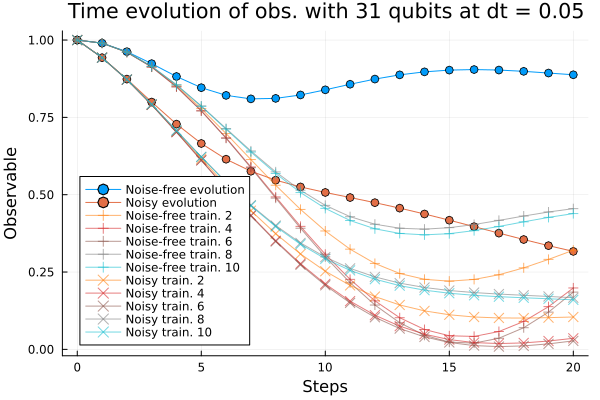

In [24]:
colors = palette(:tab10)
plot(0:steps, exact_expval_target; xlabel="Steps", label="Noise-free evolution", marker=:o, legend=:bottomleft)
plot!(0:steps, noisy_expval_target; label="Noisy evolution", marker=:o)

for i in 2:2:size(exact_expvals_training)[1]
    plot!(0:steps, exact_expvals_training[i, :]; label="Noise-free train. $i", c=colors[i], marker=:+, markersize = 5, alpha=0.6)
end

for i in 2:2:size(noisy_expvals_training)[1]
    plot!(0:steps, noisy_expvals_training[i, :]; label="Noisy train. $i", color=colors[i], marker=:x, markersize = 5, alpha=0.6)
end

plot!(ylabel="Observable", title ="Time evolution of obs. with $(nq) qubits at dt = $(round((T/steps), digits = 2))")

We observe that the training circuits look like they behave very differently from the target circuit. Well, yes. But importantly, the trotterized evolution is not modified during the evolution itself, i.e. we keep the two same angles during the whole evolution. This means our training circuits are physically relevant circuits in the sense that they all represent a physical evolution. We cannot get closer to the target evolution while still respecting the physics of our problem, as we are varying only $\theta_J$.

### 3) CDR
Just as in the original CDR paper, we start by correcting the noisy expectation value with a linear ansatz. The motivation is that this ansatz is the exact solution for a general quantum erasure noise channel, which takes the input state $\rho$ to
$$
  \rho \rightarrow (1-p_\text{error}) \rho  + p_\text{error}\ \rho_0 .
$$
Thus, we can perform least squares regression (which assumes Gaussian noise) to find the optimal parameters $a_1,a_2$ in the following relationship for the noiseless expectation value
$$
X_\psi^{\text{exact}} = f( X_\psi^{\text{noisy}},\mathbf{a} )  = a_1 + a_2 X_\psi^{\text{noisy}}.
$$
Let's define this ansatz, mapping the noisy value to the noise-corrected value.

In [25]:
lin_model(x, a) = a[1] .+ a[2] .* x;

We first correct only the last step of the time evolution.

In [26]:
noisy_expvals_training_last = noisy_expvals_training[:, end]
exact_expvals_training_last = exact_expvals_training[:, end]
noisy_expval_target_last = noisy_expval_target[end]
exact_expval_target_last = exact_expval_target[end];

Again, we need to make an initial guess of the parameters in the linear model. Using the optimized function, we can extrapolate to the noiseless value, i.e the target circuit's behavior.

In [27]:
# initial guess of the coefficient
p0 = [exact_expvals_training_last[1], (exact_expvals_training_last[end]-exact_expvals_training_last[1])/(noisy_expvals_training_last[end] - noisy_expvals_training_last[1]), 1.0]
fit_ = curve_fit(lin_model, noisy_expvals_training_last, exact_expvals_training_last, p0)
# extrapolate to 0-noise using the fitted model
corrected_CDR_last = lin_model(noisy_expval_target_last, fit_.param)

0.8072707005293721

In [28]:
abs_error_after_CDR_last = abs(exact_expval_target_last - corrected_CDR_last) 
abs_error_before_CDR_last = abs(exact_expval_target_last - noisy_expval_target_last) 

println("Noisy value at the last timestep: ", round(noisy_expval_target_last, digits = 2))
println("Corrected value at the last timestep: ", round(corrected_CDR_last, digits = 2))
println("Absolute error before correction: ", round(abs_error_before_CDR_last,digits =2))
println("Absolute error after correction: ", round(abs_error_after_CDR_last, digits = 4))

Noisy value at the last timestep: 0.32
Corrected value at the last timestep: 0.81
Absolute error before correction: 0.57
Absolute error after correction: 0.0805


Let's see what the fit looks like.

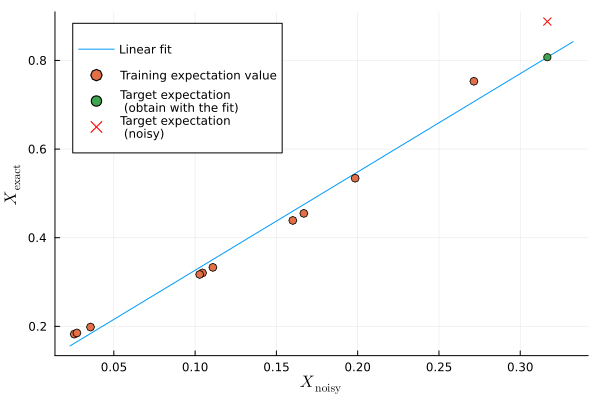

In [29]:
x = LinRange(min(minimum(noisy_expvals_training_last)*0.9, noisy_expval_target_last), max(maximum(noisy_expvals_training_last), noisy_expval_target_last)*1.05, 100)
plot(x, lin_model.(x, fill(fit_.param, length(x))), label="Linear fit")
scatter!(noisy_expvals_training_last, exact_expvals_training_last, marker=:o, label="Training expectation value")
scatter!([noisy_expval_target_last], [corrected_CDR_last], label="Target expectation\n (obtain with the fit)")
scatter!([noisy_expval_target_last], [exact_expval_target_last], label="Target expectation\n (noisy)", marker=:x, color=:red)
plot!(xlabel=L"$X_{\textrm{noisy}}$", ylabel=L"$X_{\textrm{exact}}$")

Again, we wrap this up in a nice function.

In [30]:
function cdr(noisy_exp_values::Array{Float64, 1},
            exact_exp_values::Array{Float64, 1},
            noisy_target_exp_value::Float64;
            exact_target_exp_value::Union{Nothing, Float64}=nothing)
    """
    Function that computes the CDR correction for a single noisy expectation value.
    """

    lin_model(x, p) = p[1] .+ p[2] .* x
    # initial guess of the coefficient
    p0 = [exact_exp_values[1], 0.01]
    fit_ = curve_fit(lin_model, noisy_exp_values, exact_exp_values, p0)
    # extrapolate to 0-noise using the fitted model
    corrected = lin_model(noisy_target_exp_value, fit_.param)
    
    if exact_target_exp_value === nothing
        return corrected, nothing, nothing
    end
    
    abs_error_after = abs(exact_target_exp_value - corrected) 
    abs_error_before = abs(exact_target_exp_value - noisy_target_exp_value) 
    return corrected, abs_error_after, abs_error_before
end;

## example of a function call to compute the corrected value at the last time step:
# corr_CDR_last, abs_error_after_CDR_last, abs_error_before_CDR_last = cdr(
#     noisy_expvals_training_last,
#     exact_expvals_training_last,
#     noisy_expval_target_last,
#     exact_expval_target_last
# )

cdr (generic function with 1 method)

We now do CDR for all time steps to visualize the evolution of the correction. As before for ZNE, we are only considering the current time step for our correction. It is important to note that we cannot continuously correct the time evolution because we have cannot correct the state itself. Instead, we are only correcting the expectation values.

In [31]:
corrected_CDR = Array{Float64, 1}(undef, steps+1)
abs_error_after_CDR = Array{Float64, 1}(undef, steps+1)
abs_error_before_CDR = Array{Float64, 1}(undef, steps+1)
for i in 1:steps+1
    corrected_CDR[i], 
    abs_error_after_CDR[i],
    abs_error_before_CDR[i] = cdr(
        noisy_expvals_training[:, i],
        exact_expvals_training[:, i],
        noisy_expval_target[i];
        exact_target_exp_value=exact_expval_target[i])
end

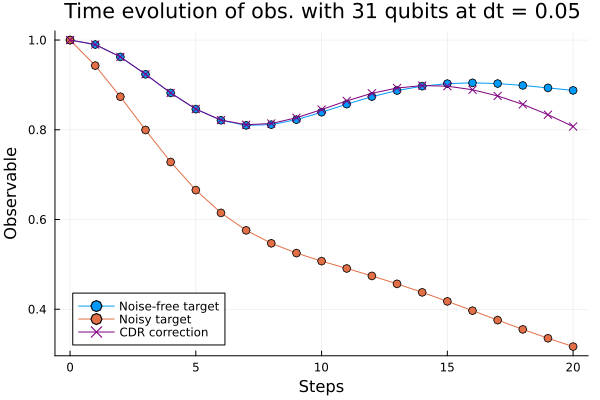

In [32]:
#plot time evolution
plot(0:steps, exact_expval_target; xlabel="Steps", label="Noise-free target", marker=:o, legend=:bottomleft)
plot!(0:steps, noisy_expval_target; label="Noisy target", marker=:o)
plot!(0:steps, corrected_CDR; label="CDR correction", marker=:x, color = "purple")

plot!(ylabel="Observable", title ="Time evolution of obs. with $(nq) qubits at dt = $(round((T/steps), digits = 2))")

CDR is quite performant until step 8 before visibly deviating from the exact evolution. This can be explained by the fact that noise does not follow the exact evolution trend anymore: it keeps decreasing even though the noiseless expectation value increases again from step 7. Thus, it becomes impossible to find a meaningful relationship between noiseless and noisy expectation values.

This hypothesis can be easily verified by changing the noise strength! For `depol_strength` and `dephase_strength` equal to 0.1, CDR performs well until step 14.

# vnCDR
The CDR and ZNE methods can be combined to form a new error correction method. In the original paper, the vnCDR outperforms both its constituents on a Variational Quantum Algorithms setup. For quantum dynamics, as in our case, there is no clearly better method. 

For each circuit from the training set, one calculates the expectation value at multiple noise levels, as well as the corresponding noiseless expectation value. Note here that vnCDR works with the varied noise levels of the *training* circuits, while ZNE works with the varied noise levels of the *target* circuit.

More precisely, we will be implementing CPDR-ZNE as described in the CPA paper. This is based on the same idea as vnCDR, but allows for a small angle perturbation from Cliffords in the training circuit generation.

We first compute the noiseless expectation values for our training circuits.

In [33]:
exact_expvals_training_levels = Array{Float64,2}(undef, length(list_training_thetas), steps+1)
# iterate over training circuits (i.e. different thetas)
for (i, thetas) in enumerate(list_training_thetas)
    exact_expvals_training_levels[i, :] = trotter_time_evolution(
        steps, layer, observable, thetas;
        noise=false,
        min_abs_coeff, max_weight,
        depol_strength, dephase_strength)
end

We now compute the noisy expectation values with different noise levels for each training circuit.

In [34]:
noisy_expvals_training_levels = Array{Float64,3}(undef, length(noise_levels), length(list_training_thetas), steps+1) # 3D array: (noise_levels, circuits, steps+1)
# iterate over noise levels
for (idx, level) in enumerate(noise_levels)
    # iterate over training circuits (i.e. different thetas)
    for (i, thetas) in enumerate(list_training_thetas)
        noisy_expvals_training_levels[idx, i, :] = trotter_time_evolution(
            steps, layer, observable, thetas;
            noise=true, noise_level=level,
            min_abs_coeff, max_weight,
            depol_strength, dephase_strength)
    end
end

In [35]:
noisy_expvals_training_levels_last = noisy_expvals_training_levels[:,:,end];

In [36]:
exact_expvals_training_last = exact_expvals_training[:,end];

We use vnCDR to correct the last step of the time evolution:

In [37]:
# linear regression
model = LinearRegressor(fit_intercept = false);

# Convert input matrix to DataFrame
X = DataFrame(noisy_expvals_training_levels_last', :auto);
mach = machine(model, X, exact_expvals_training_last);
fit!(mach);
params = fitted_params(mach);

# Manually compute prediction
coefs = [v for (_, v) in params.coefs]
corrected_vnCDR_last = coefs'* noisy_exp_last
abs_error_after_vnCDR_last = abs(exact_expval_target[end] - corrected_vnCDR_last)
abs_error_before_vnCDR_last = abs(exact_expval_target[end] - noisy_exp_last[1]) 

println("Noisy value at the last timestep: ", round(noisy_expval_target_last, digits = 2))
println("Corrected value at the last timestep: ", round(corrected_vnCDR_last, digits = 2))
println("Absolute error before correction: ", round(abs_error_before_vnCDR_last, digits = 2))
println("Absolute error after correction: ", round(abs_error_after_vnCDR_last, digits = 8))
     


┌ Info: Training machine(LinearRegressor(fit_intercept = false, …), …).
└ @ MLJBase /home/julia/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Solver: Analytical
│   iterative: Bool false
│   max_inner: Int64 200
└ @ MLJLinearModels /home/julia/.julia/packages/MLJLinearModels/yYgtO/src/mlj/interface.jl:27


Noisy value at the last timestep: 0.32
Corrected value at the last timestep: 0.9
Absolute error before correction: 0.57
Absolute error after correction: 0.00798485


Again, we wrap this up in a function to make things easier.

In [38]:
function vnCDR(
    noisy_exp_values::Array{Float64,2},         # size (m circuits, n+1 noise levels)
    exact_exp_values::Array{Float64,1},         # size m
    noisy_target_exp_value::Array{Float64, 1};  # size n+1
    exact_target_exp_value::Union{Nothing, Float64}=nothing)
    # linear regression
    model = LinearRegressor(fit_intercept = false);

    # Convert input matrix to DataFrame
    params = 0
    # we add the following line to avoid invasing logging information 
    with_logger(Logging.SimpleLogger(stderr, Logging.Warn)) do
        X = DataFrame(noisy_exp_values', :auto)
        mach = machine(model, X, exact_exp_values)
        fit!(mach)
        params = fitted_params(mach)
    end

    # Manually compute prediction
    coefs = [v for (_, v) in params.coefs]
    corrected = coefs'* noisy_target_exp_value
    
    if exact_target_exp_value === nothing
        return corrected, nothing, nothing
    end
    # absolute errors before and after correction
    abs_error_before = abs(exact_target_exp_value - noisy_target_exp_value[1]) 
    abs_error_after = abs(exact_target_exp_value - corrected)
    
    return corrected, abs_error_after, abs_error_before
end;


## example of a function call to compute the corrected value at the last time step
# corrected, abs_error_after, abs_error_before = vnCDR(noisy_expvals_training_levels_last, 
#                                                     exact_expvals_training_last,         
#                                                     noisy_exp_last,
#                                                     exact_expval_target[end])


vnCDR (generic function with 1 method)

We now correct the values for each time step.

In [39]:
corrected_vnCDR = Array{Float64, 1}(undef, steps+1)
abs_error_after_vnCDR = Array{Float64, 1}(undef, steps+1) 
abs_error_before_vnCDR = Array{Float64, 1}(undef, steps+1)
# perform vnCDR on every time step 
for i in 1:steps+1
    corrected_vnCDR[i], abs_error_after_vnCDR[i], abs_error_before_vnCDR[i] = vnCDR(
        noisy_expvals_training_levels[:, :, i],
        exact_expvals_training[:, i],
        noisy_expval_target_levels[:,i];
        exact_target_exp_value=
        exact_expval_target[i])
end

### Comparison plot of all methods
We now plot the final results from vnCDR and compare these to the results from its components, ZNE and CDR.

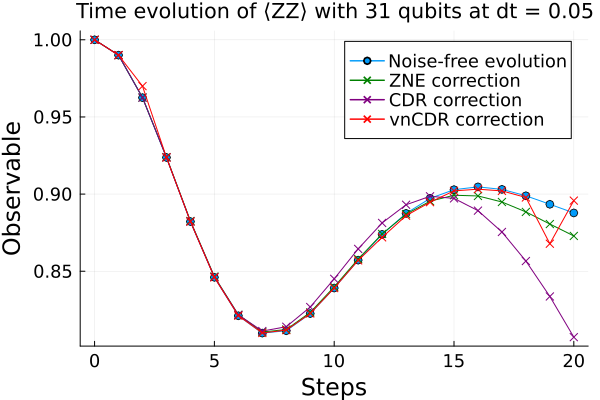

In [40]:
plot(0:steps, exact_expval_target; xlabel="Steps", label="Noise-free evolution", marker=:o, legend=:topright, guidefontsize=16,
            tickfontsize=12,
            legendfontsize=12)
# plot!(0:steps, noisy_expval_target; label="Noisy evolution", marker=:o, legend=:bottomleft)
plot!(0:steps, corrected_ZNE, label="ZNE correction", marker=:x, color ="green")
plot!(0:steps, corrected_CDR; label="CDR correction", marker=:x, color="purple")
plot!(0:steps, corrected_vnCDR; label="vnCDR correction", marker=:x, color="red")
plot!(ylabel="Observable", title ="Time evolution of ⟨ZZ⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")

vnCDR overcomes the difficulty CDR has correcting the noisy evolution once the exact and noisy evolution do not follow the same trend. For this specific system, vnCDR has a higher accuracy than ZNE. This is not generalizable, if we look at other Hamiltonians and hyper parameters this may change. Also, vnCDR is generally faster than CDR (as we show later).
On the other hand, vnCDR is not as reliable as ZNE. It seldom produces unexplained behavior for individual time steps.

Let us compare these different methods by looking it at the absolute error. We cannot start from the first time steps, because we have an absolute error of 0 for some methods which cannot be plotted in log-scale.

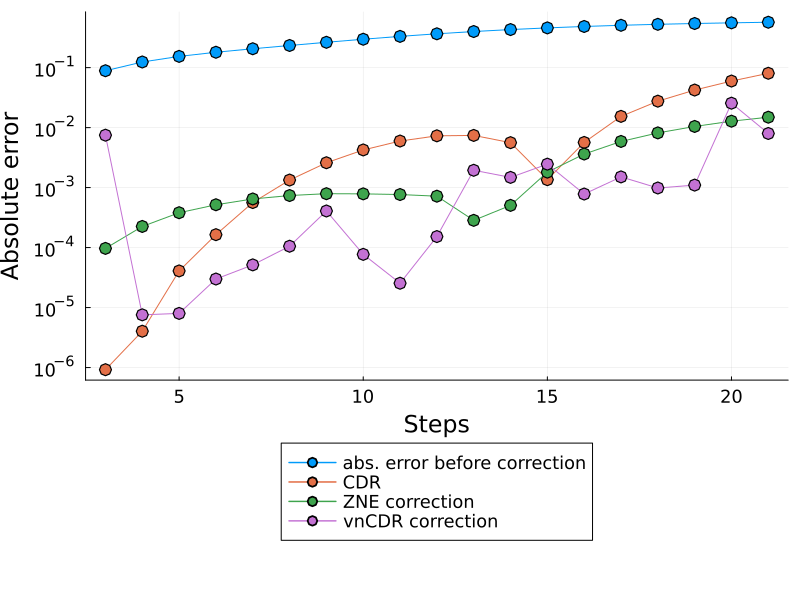

In [41]:
start = 3

# we plot the absolute error before cdr here but obviously the 
# absolute error at the beginning is the same for every method
plot(start:steps+1, abs_error_before_CDR[start:end], xlabel="Steps", ylabel = "Absolute error", label="abs. error before correction", marker=:o, legend=:outerbottom, yscale=:log10, ms = 6)

plot!(start:steps+1, abs_error_after_CDR[start:end], label="CDR", marker=:o, ms = 6)
plot!(start:steps+1, abs_error_after_ZNE[start:end], label="ZNE correction", marker=:o, ms = 6)
plot!(start:steps+1, abs_error_after_vnCDR[start:end], label="vnCDR correction", marker=:o, yscale=:log10, ms = 6)

plot!(yticks=10.0 .^ (-1:-1:-8), size=(800, 600), guidefontsize=16,
            tickfontsize=12,
            legendfontsize=12)

We can see here that even though ZNE performs more consistently than vnCDR, the absolute error is often slightly larger for ZNE. However, the important thing to note is that the computational effort for vnCDR is much lower than for ZNE when using PP, due to the small angle regime leverage in vnCDR. This may not be apparent for small systems but becomes important for larger systems and/or lower truncations, as we will see in the utility experiment calculations.

CDR is very good as long as the noisy values follows the same trend as the noiseless ones. This method will become increasingly interesting as the quantum computers will achieve low noise.

In conclusion, vnCDR presents a good efficiency-accuracy tradeoff while ZNE seems more regular. CDR should be kept for expectation values with a low noise.

# Correcting the Utility Experiment
### Defining the system and functions
We now apply all our techniques to the utility experiment from IBM. We use 127 qubits and the heavy hex topology from the eagle QPU. The system simulated is slightly different, as $\theta_J$ is fixed at $\pi/2$: this is the kicked transverse Ising field model. The simulations are simplified as the ZZ Pauli rotation gates become Clifford gates with $\theta_J=\pi/2$. $\theta_h$ varies, and the local observable is $\langle Z_{62} \rangle$.

In [42]:
nq = 127
nl= 20
dt = 0.05
T = nl*dt
J = pi/2
topology = ibmeagletopology;
observable = PauliSum(nq); add!(observable, :Z, 62);

Let's define the `kickedisingcircuit`, which only has parameterized gates for the h values.

In [43]:
function kickedisingcircuit(nq, nl; topology=nothing)

    """
    generates a circuit with nq qubits and nl layers where the RX angle is a variable and the RZZ angle is fixed to -π/2
    """
    
    xlayer(circuit) = append!(circuit, (PauliRotation([:X], [qind]) for qind in 1:nq))
    zzlayer(circuit) = append!(circuit, (PauliRotation([:Z, :Z], pair, -π/2) for pair in topology))

    circuit = Gate[]

    for _ in 1:nl
        zzlayer(circuit)
        xlayer(circuit)
    end

    return circuit
end

kickedisingcircuit (generic function with 1 method)

Then, we can again define one layer of our circuit.

In [44]:
layer = kickedisingcircuit(nq, 1, topology=topology);

As previously mentioned, we cannot use our "augmented" approach for vnCDR in some cases: here, $\theta_h$ will take 2 values smaller than the angle range $\pi/20$ (namely 0 and 0.1) and $\theta_J$ is fixed. We do not want to reduce further our angle range so that $\theta_h$ would be greater than it, because our training circuits would be too similar to each other. Thus, we use a "strict" approach (strict in the sense that it is closer to the original CPA approach): we change $\theta_h$ even though it is smaller than the angle range. 

The difference with the procedure presented in the CPA paper is that we choose the angles of the training circuits at random, instead of taking the ones predefined in $\mathcal{T}$. This allows to reach similar results with much less training circuits (here we will use `num_samples=10` instead of the 144 used in the paper).

In [45]:
function strict_training_set_generation(layer, dt,J,h,angle_range,num_samples)
    training_thetas_list = Vector{Vector{Float64}}()
    thetas = define_thetas(layer, dt, J, h)
    training_thetas = deepcopy(thetas)
    theta_h_indices = getparameterindices(layer, PauliRotation, [:X])
    for _ in 1:num_samples
        new_tht_h = rand(Uniform(0.0, angle_range))
        training_thetas[theta_h_indices] .= new_tht_h
        push!(training_thetas_list, copy(training_thetas))
    end
    return training_thetas_list
end

strict_training_set_generation (generic function with 1 method)

In order to make the code more readable, we define a loop over the `trotter_time_evolution` function, which we use when we want to time evolve a whole training set.

In [46]:
function training_trotter_time_evolution(
    steps::Int,
    layer::Vector{Gate},
    observable::PauliSum,
    training_thetas::Vector{Vector{Float64}};
    noise=false,
    min_abs_coeff=0.0,
    max_weight=Inf,
    depol_strength=0.01,
    dephase_strength=0.01,
    noise_level=1.0
)
    n_circuits = length(training_thetas)
    trajectories = Array{Float64,2}(undef, n_circuits, steps+1)
    for (i, θ) in enumerate(training_thetas)
        trajectories[i, :] = trotter_time_evolution(
            steps, layer, observable, θ;
            noise=noise,
            min_abs_coeff,
            max_weight,
            depol_strength,
            dephase_strength,
            noise_level
        )
    end
    return trajectories
end


training_trotter_time_evolution (generic function with 1 method)

The data set containing the unmitigated expectation values can be found in the supplements of the utility paper.
IBM further provides results of their ZNE error mitigation (`IBM_mitigated_vals`).
We further use data from a tensor network from Flatiron for comparison.

In [47]:
# unmitigated data (which we will feed into our error mitigation methods)
mixed_angles = [0.3, 1.0, 0.7, 0.0, 0.2, 0.8, 0.5, 0.1, 0.4, 1.5707, 0.6];
IBM_unmitigated_vals = [ 0.4188991191900761,
0.004107759335343423,
0.11944580478416555,
0.49038646460776864,
0.4552471452020139,
0.055064655494323766,
0.3061535376123831,
0.4889782663914668,
0.3622122171682965,
-0.001980699802309258,
0.20175539633925924]

# data for comparison from IBM
IBM_angles = [0.    , 0.1   , 0.2   , 0.3   , 0.4   , 0.5   , 0.6   , 0.7   , 0.8   , 1.    , 1.5707]
IBM_mitigated_vals = [1.01688859, 1.00387483, 0.95615886, 0.95966435, 0.83946763,
    0.81185907, 0.54640995, 0.45518584, 0.19469377, 0.01301832,0.01016334]

# data for comparison from Flatiron tensor network
tn_vals = [9.99999254e-01,  9.99593653e-01,  9.95720077e-01,  9.88301532e-01,
        9.78553511e-01,  9.58023054e-01,  9.21986059e-01,  8.81726079e-01,
        8.49816779e-01,  8.24900527e-01,  7.91257641e-01,  7.37435202e-01,
        6.68573798e-01,  5.88096040e-01,  4.81874079e-01,  3.50316579e-01,
        2.26709331e-01,  1.39724659e-01,  7.86639143e-02,  4.24124371e-02,
        1.90595136e-02,  6.18879050e-03, -8.27168956e-04, -4.63372099e-03,
       -7.05202121e-03, -7.68387421e-03, -6.33121142e-03, -4.32594440e-03,
        6.52050191e-04,  1.72598340e-04,  5.64696020e-05, -7.70582375e-07]
tn_angles = LinRange(0, π/2, length(tn_vals));

We set the truncation coefficients so that this section can be run within 2 minutes on a laptop, and requires around 1.5 GB of memory in total (`min_abs_coeff = 1e-4`, `max_weight = 10`). Keep in mind that you should not choose too low truncation coefficients, otherwise the calculations become untractable! For truncation order of `1e-5`and max weight `10`, the code runs 25 minutes and the total allocated memory is 7 GB for example.
We stick to 6 noise levels and keep the `angle_range` at $\pi/20$. The noise strength for both depolarizing and dephasing noise was chosen so that it approximately matches the unmitigated IBM values at strength `1.0`, as we will show and discuss in the final plot (ZNE base noise level). 

In [48]:
angle_range = pi/20
min_abs_coeff = 1e-4
max_weight = 10
depol_strength = 4/3*0.018 # same as in the previous example
dephase_strength = 2*0.012
noise_levels = [1.0, 1.3, 1.5, 1.8, 2.0, 2.2];
num_samples = 10

10

## Error mitigating the utility experiment
Now that we have all functions prepared, we can execute all error mitigation methods for the varying $\theta_h$ values. 

In [49]:
# initialize arrays to collect results
collect_zne = Float64[]; collect_cdr = Float64[]; collect_vncd = Float64[]
base_noise_zne = Float64[] # we use this to calibrate the ZNE method
h_values = mixed_angles .* nl/(2*T)

# time ZNE vs vnCDR
execution_times_ZNE = Float64[]
execution_times_vnCDR = Float64[]

# we loop over the h values
@time for (i,h) in enumerate(h_values)

    # CDR and vnCDR use the same "strict" training set
    training_thetas = strict_training_set_generation(layer, dt, J, h, angle_range, num_samples) #we do not need J here (there are no ZZ parametrized gates in the circuit) but we need to set it to a value for define_thetas to work.
    
    # CDR: evolve the noiseless training circuits
    exact_train = training_trotter_time_evolution(
        nl, layer, observable, training_thetas; noise = false,
        min_abs_coeff, max_weight,
        noise_level=0.0, depol_strength, dephase_strength)
    
    # we only need the last time step of CDR
    exact_train = exact_train[:, end] 

    # vnCDR: evolve the noise-scaled training circuits
    vnCDR_levels = Array{Float64,3}(undef, length(noise_levels), length(training_thetas), nl+1)
    time_vnCDR = @elapsed for (idx, i) in enumerate(noise_levels)
        noisy_training = training_trotter_time_evolution(
            nl, layer, observable, training_thetas; noise = true, noise_level=i,
            min_abs_coeff, max_weight,
            depol_strength, dephase_strength)
        for j in 1:length(training_thetas)
            vnCDR_levels[idx, j, :] .= noisy_training[j, :]
        end
    end

    # note that the first noise level of vnCDR is exactly what we need for CDR
    noisy_train = vnCDR_levels[1,:,end]

    # ZNE: we need the thetas of the original circuit, not the training thetas
    thetas = define_thetas(layer, dt, J, h)

    zne_levels = Array{Float64,2}(undef, length(noise_levels), nl+1)
    time_zne = @elapsed for (idx,i) in enumerate(noise_levels)
        expval_target = trotter_time_evolution(
            nl, layer, observable, thetas;noise = true, noise_level=i,
            min_abs_coeff, max_weight,
            depol_strength, dephase_strength)
        zne_levels[idx,:] .= expval_target
    end

    # we only need the last time step of ZNE
    zne_levels = zne_levels[:, end]
    # we store the base noise level for ZNE (noise_level = 1.0)
    push!(base_noise_zne, zne_levels[1])

    # we store the execution times for ZNE and vnCDR
    push!(execution_times_ZNE, time_zne)
    push!(execution_times_vnCDR, time_vnCDR)
    ### evaluation of the error mitigation methods
    
    # CDR results
    result_cdr,_,_ = cdr(
        noisy_train, exact_train,
        IBM_unmitigated_vals[i])

    # vnCDR results
    result_vnCDR,_,_ = vnCDR(
        vnCDR_levels[:, :, end],
        exact_train,
     zne_levels)

    # ZNE results
    result_zne,_,_ = zne(zne_levels,
    noise_levels)
    
    # add our results for each h value
     push!(collect_cdr, result_cdr)
     push!(collect_zne, result_zne)
     push!(collect_vncd, result_vnCDR)
end

 78.847839 seconds (19.07 M allocations: 1.463 GiB, 0.68% gc time, 0.71% compilation time)


In [50]:
println("ZNE execution time in s: ", round.(sum(execution_times_ZNE), digits = 2))
println("vnCDR execution time in s: ", round.(sum(execution_times_vnCDR), digits = 2))

ZNE execution time in s: 72.29
vnCDR execution time in s: 4.21


Here we see clearly, that vnCDR is much faster than ZNE. Consequently, CPA is fast as well.

Now that we have generated all our data, let's plot the results! If the truncation order is chosen to too high, some point (especially for ZNE) might lie outside the plausible interval of $[0,1]$. Then we can filter those values and report they are missing in the plot.
You can run this simulation with lower truncations to get stable results.

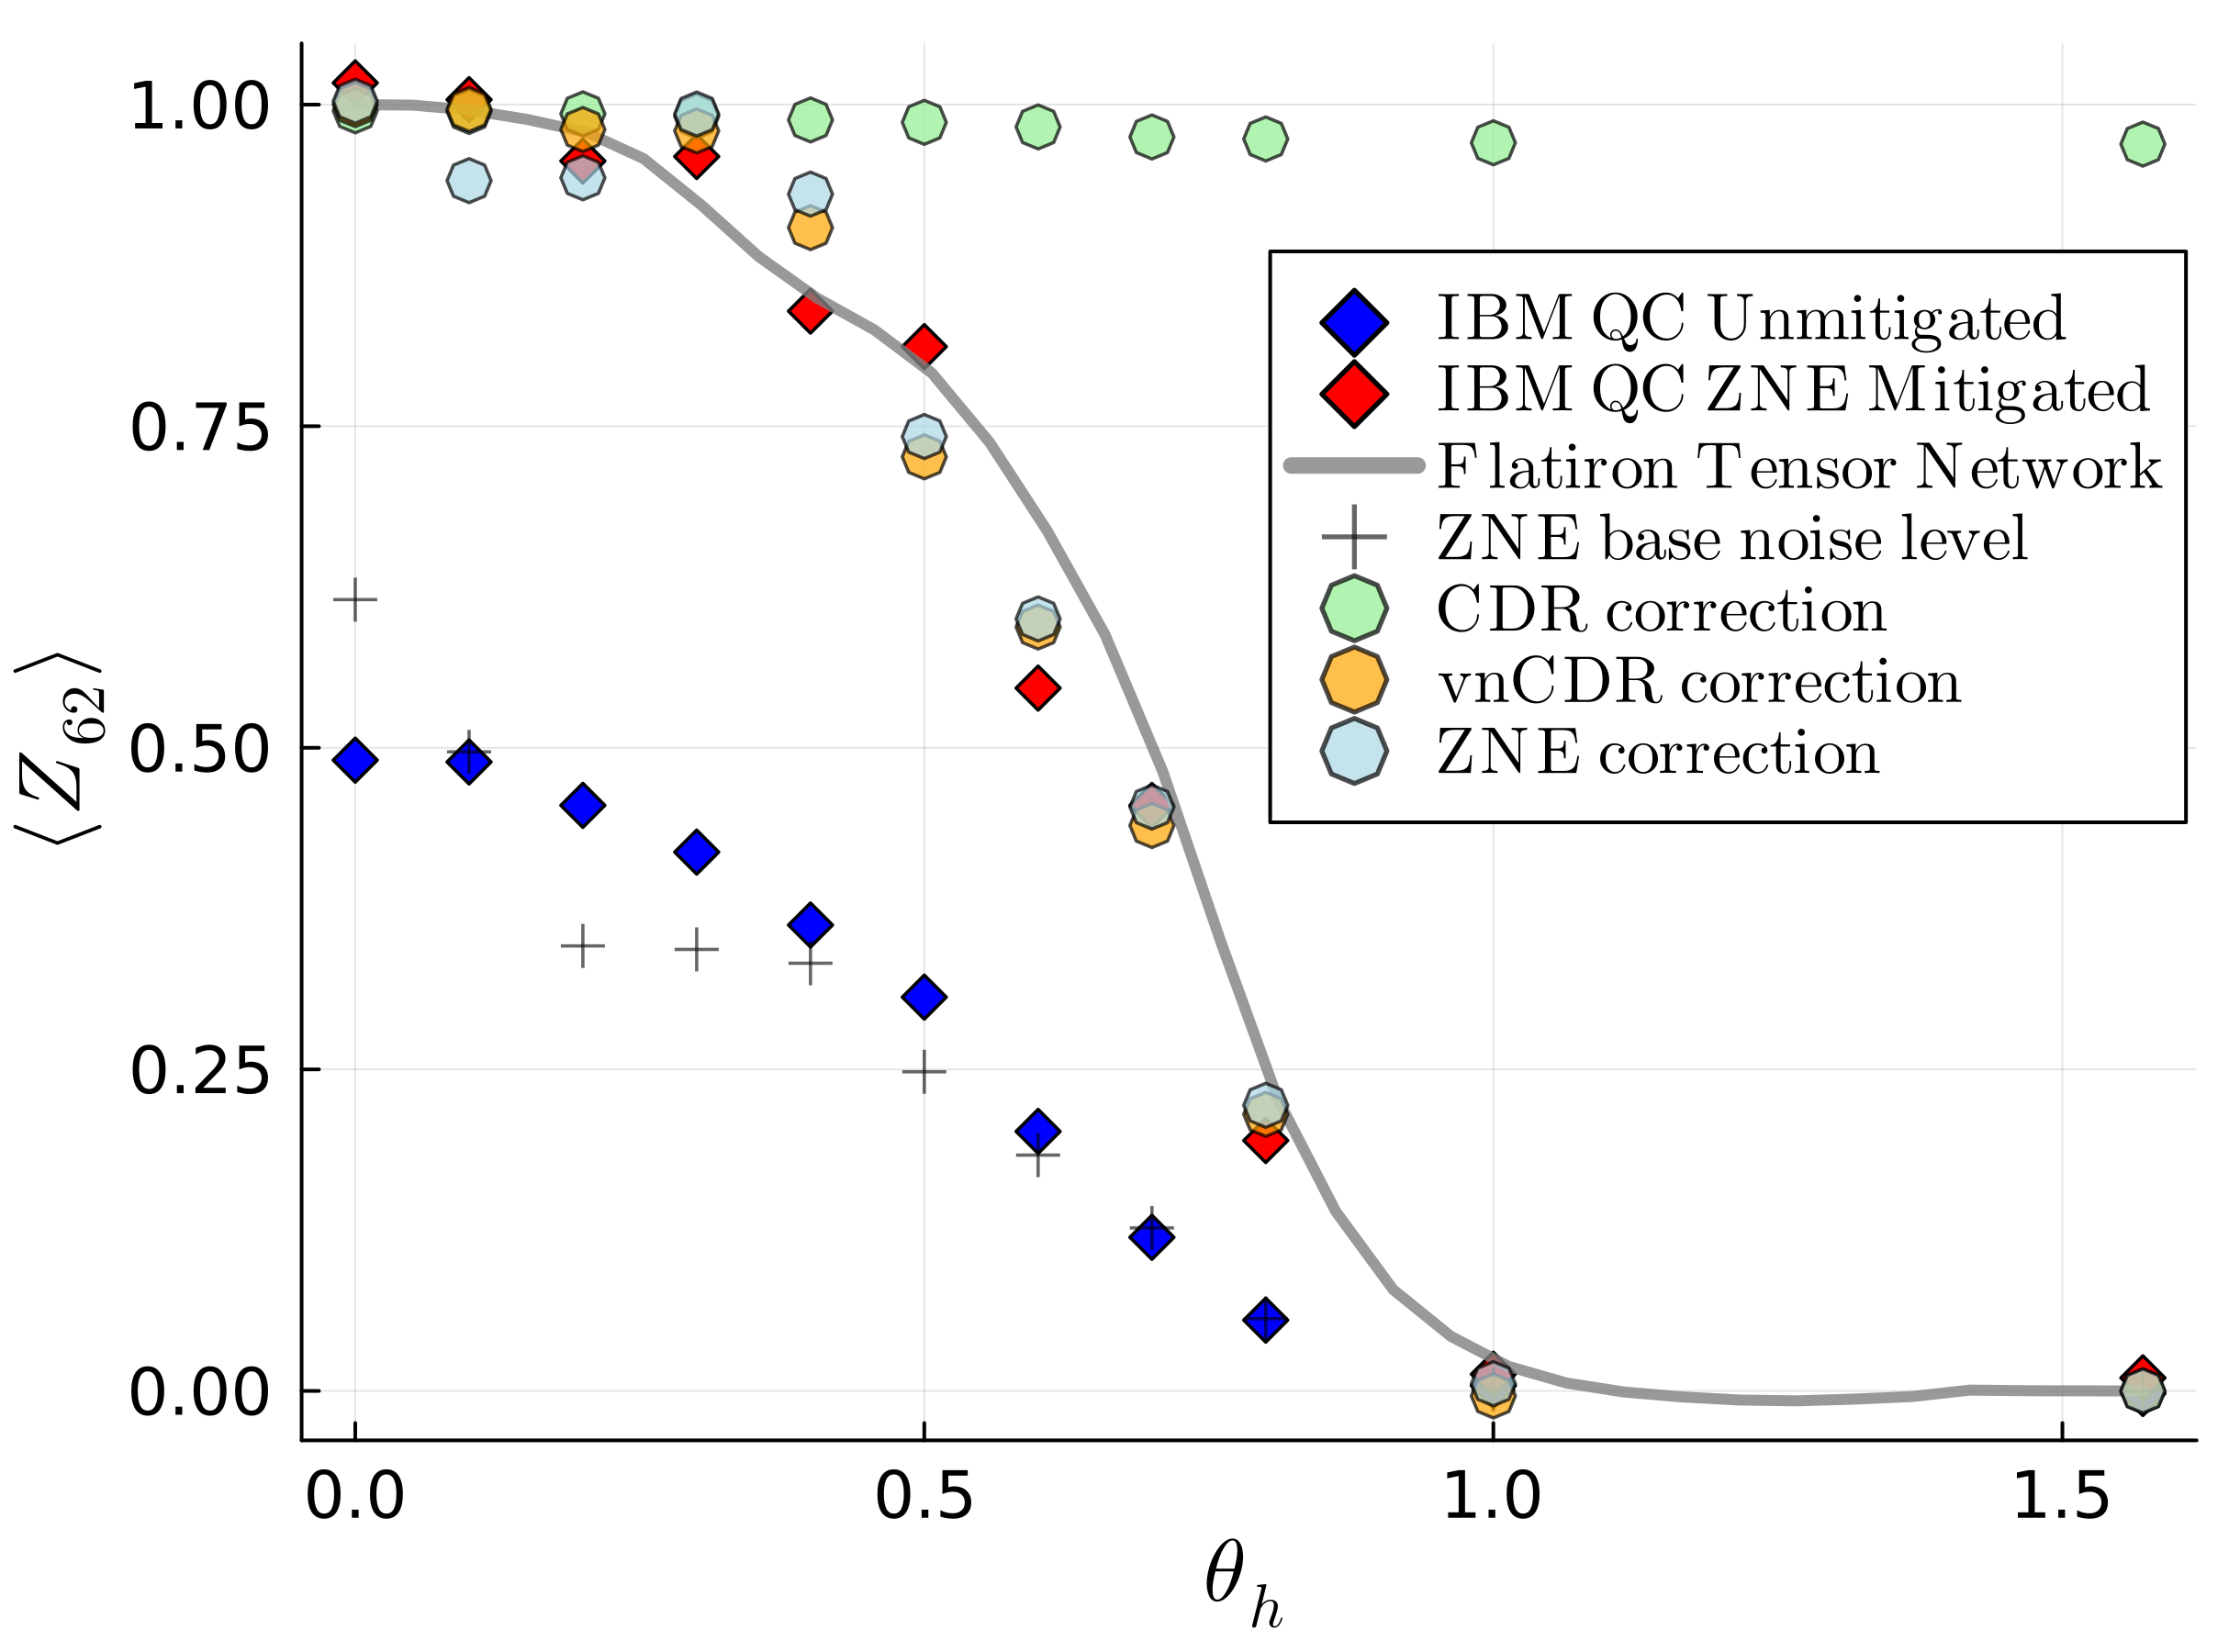

In [51]:
# Toggle to enable or disable filtering of y values
filter_data = false

# Use filtering if enabled, else use original data
if filter_data
    zne_xs = [x for (x, y) in zip(mixed_angles, collect_zne) if 0 <= y <= 1]
    zne_ys = [y for (x, y) in zip(mixed_angles, collect_zne) if 0 <= y <= 1]

    cdr_xs = [x for (x, y) in zip(mixed_angles, collect_cdr) if 0 <= y <= 1]
    cdr_ys = [y for (x, y) in zip(mixed_angles, collect_cdr) if 0 <= y <= 1]

    vncd_xs = [x for (x, y) in zip(mixed_angles, collect_vncd) if 0 <= y <= 1]
    vncd_ys = [y for (x, y) in zip(mixed_angles, collect_vncd) if 0 <= y <= 1]
else
    zne_xs, zne_ys = mixed_angles, collect_zne
    cdr_xs, cdr_ys = mixed_angles, collect_cdr
    vncd_xs, vncd_ys = mixed_angles, collect_vncd
end

# Plot
scatter(mixed_angles, IBM_unmitigated_vals, label=L"\textrm{IBM\ QC\ Unmitigated}", marker=:diamond, 
        color=:blue, lw=2, guidefontsize=16, tickfontsize=12, legendfontsize=12, ms=6, dpi = 400)
scatter!(IBM_angles, IBM_mitigated_vals, label=L"\textrm{IBM\ QC\ ZNE\ Mitigated}", color="Red", ms=6, marker=:diamond)
plot!(tn_angles, tn_vals, label=L"\textrm{Flatiron\ Tensor\ Network}", color="grey", alpha=0.8, linewidth=3, ms=6)
scatter!(mixed_angles, base_noise_zne, label=L"\textrm{ZNE\ base\ noise\ level}", color="black", marker=:cross , ms=6, alpha = 0.6)
# Correction results
scatter!(cdr_xs, cdr_ys, label=L"\textrm{CDR\ correction}", color="lightgreen", linewidth=3, ms=6, marker=:o, alpha=0.7)
scatter!(vncd_xs, vncd_ys, label=L"\textrm{vnCDR\ correction}", color="orange", ms=6, marker=:o, alpha=0.7, legend_position=(0.6, 0.8))
scatter!(zne_xs, zne_ys, label=L"\textrm{ZNE\ correction}", color="lightblue", ms=6, marker=:o, alpha=0.7)
plot!(legend_position=(0.6, 0.8), xlabel=L"\theta_h",
      ylabel=L"\langle Z_{62} \rangle", size=(610,450), dpi=400)

Unsurprisingly, CDR fails beyond the small-angle regime. This is explained by the fact that near-Clifford circuits are not close enough to the target circuit angle. Thus, the pattern learned is not meaningful for our target circuit. However for quantum dynamics, the small angle regime is more relevant, as we want a good time resolution. Thus, CDR (more precisely CPA) still has potential for this application.

vnCDR and ZNE give similar results as IBM mitigated values. This is a satisfying result, given the fact that our noise model is very simple here, and is not adapted to the specifications of IBM's hardware. As mentioned above, we adjusted the noise strength for ZNE so that the base noise level lies approximately on or below the noisy hardware expectation values. This is done because, if we were to run the scaled noisy circuits on the quantum computer, we cannot go below the base noise level. For $\theta_h = 0$, the expectation value stays above the hardware data. This is because, for this angle, all $R_{X_i}\left(\theta_h\right)$ gates are identity. As we can see in the `applynoiselayer` function, the resulting depolarizing noise is determined by the weight (number of non-identity terms) of each Pauli string, while the resulting dephasing noise is determined by the number of X or Y Paulis. So, this data point stays above the hardware data, even for larger noise. We can accept this, because we can efficiently simulate fully Clifford circuits.

If we want to perform purely classical simulations, we can also opt not to calibrate the base noise level, which gives similar results and works well for this system size. Then vnCDR is the better choice because it requires less computational ressources and we can push the boundaries of classical simulations further.

To improve the correction, making the noise model more realistic is likely the main opportunity for improvement.

As we have seen, the utility experiment is sufficiently easy to be fully classically simulated with classical simulation methods such as Pauli Propagation or tensor networks. Nevertheless, the performance of our implemented methods indicates that they will also scale for the quantum dynamics of larger systems, which cannot yet be classically simulated to high precision. On the current scale, error mitigation mainly reduces the execution time. IBM's MPS comparison took 30 hours per data point, while we get away with a few minutes in trade-off for some accuracy.